In [1]:
import numpy as np

from helpers import *
from implementations import ridge_regression
from functions import abs_dif, inv_log, mult 
from preprocessing import replace_invalid, standardize
from feature_eng import build_poly
from cross_validation import cross_validation_ridge
from predictions import predict_labels

In [2]:
y_train, x_brute_train, _ = load_csv_data("../data/train.csv")

In [3]:
_, x_brute_test, indices_test = load_csv_data("../data/test.csv")

In [4]:
y_train.shape, x_brute_train.shape, x_brute_test.shape

((250000,), (250000, 30), (568238, 30))

In [5]:
x_brute = np.concatenate((x_brute_train, x_brute_test))
x_brute.shape

(818238, 30)

In [6]:
train_size = x_brute_train.shape[0]
test_size = x_brute_test.shape[0]

train_size, test_size

(250000, 568238)

In [7]:
invalid_value = -999

In [8]:
features_name = ["DER_mass_MMC","DER_mass_transverse_met_lep","DER_mass_vis","DER_pt_h","DER_deltaeta_jet_jet","DER_mass_jet_jet","DER_prodeta_jet_jet","DER_deltar_tau_lep","DER_pt_tot","DER_sum_pt","DER_pt_ratio_lep_tau","DER_met_phi_centrality","DER_lep_eta_centrality","PRI_tau_pt","PRI_tau_eta","PRI_tau_phi","PRI_lep_pt","PRI_lep_eta","PRI_lep_phi","PRI_met","PRI_met_phi","PRI_met_sumet","PRI_jet_num","PRI_jet_leading_pt","PRI_jet_leading_eta","PRI_jet_leading_phi","PRI_jet_subleading_pt","PRI_jet_subleading_eta","PRI_jet_subleading_phi","PRI_jet_all_pt"]

In [9]:
PHI_features = [i for i, f in enumerate(features_name) if ("_phi" in f) and ("_phi_" not in f)]

PHI_features

[15, 18, 20, 25, 28]

# Conditioning on features 22

In [10]:
def verify_masks(masks):
    total = 0
    for mask in masks:
        num = mask.sum()
        print(num)
        total += num
    assert total == x_brute.shape[0]
    return len(masks)

In [11]:
data_masks = [
    x_brute[:, 22] == 0,
    x_brute[:, 22] == 1,
    x_brute[:, 22] > 1
]
        
verify_masks(data_masks)

327371
252882
237985


3

### Mask on Y

In [12]:
ys_train = [y_train[mask[:train_size]] for mask in data_masks]

[y.shape for y in ys_train]

[(99913,), (77544,), (72543,)]

### Mask on X

In [13]:
mask_phi_features = range_mask(30, PHI_features)

In [14]:
features_masks = [(x_brute[m].std(axis=0) != 0) & np.any(x_brute[m] != -999., axis=0) & ~mask_phi_features for m in data_masks]

In [15]:
xs_brute_train = [x_brute_train[d_m[:train_size]][:, f_m] for d_m, f_m in zip(data_masks, features_masks)]

[x.shape for x in xs_brute_train]

[(99913, 15), (77544, 18), (72543, 25)]

In [16]:
xs_brute_test = [x_brute_test[d_m[train_size:]][:, f_m] for d_m, f_m in zip(data_masks, features_masks)]

[x.shape for x in xs_brute_test]

[(227458, 15), (175338, 18), (165442, 25)]

In [63]:
def build_x(x_train, x_test, degree, root=None, replace_by="mf", f_mask=None,
            log_degree=None, inv_log_degree=None, fn_log=True, fn_inv_log=True,
            functions=[mult, abs_dif], print_=False):
    
    assert f_mask == None or len(f_mask) == x.shape[1]
    assert log_degree == None or type(log_degree) == int
    assert inv_log_degree == None or type(log_degree) == int
    
    train_size = x_train.shape[0]
    test_size = x_test.shape[0]
    
    x = np.concatenate((x_train, x_test))
    
    if f_mask != None:
        x = x[:, f_mask]
    
    # Preprocessing
    if print_:
        print("Starting pre-processing")
    x = replace_invalid(x, x != invalid_value, replace_by="mf")

    x_non_negative = x - x.min(axis=0)
    x_std = standardize(x)
    
    # Features Engineering
    # poly
    if print_:
        print("Starting poly")
    x = build_poly(x_std, degree)
    
    if log_degree != None:
        x_log = standardize(np.log(1 + x_non_negative))
        x = np.concatenate((x, build_poly(x_log, log_degree)), axis=1)
    if inv_log_degree != None:
        x_inv_log = standardize(inv_log(x_non_negative))
        x = np.concatenate((x, build_poly(x_inv_log, log_degree)), axis=1)
    if root != None:
        x = np.concatenate((x, build_poly(x_non_negative, root, roots=True)), axis=1)
    
    # combinations with functions
    if print_:
        print("Starting combinations")
    x_comb = x_std
    if fn_log:
        x_comb = np.concatenate((x_comb, x_log), axis=1)
    if fn_inv_log:
        x_comb = np.concatenate((x_comb, x_inv_log), axis=1)
    for fn in functions:
        x = np.concatenate((x, combinations_of(x_comb, fn, create_pairs(x_comb.shape[1], x_comb.shape[1]))), axis=1)
    
    x = np.concatenate((np.ones(x.shape[0]).reshape((x.shape[0], 1)), x), axis=1)
    
    if print_:
        print("Final shape: {}".format(x.shape))
    
    return x[:train_size], x[train_size:]

In [64]:
lambdas = [1e-05, 1e-05, 1e-05]
k_fold = 4

degrees = [6, 11, 11]
log_degrees = [5, 5, 5]
inv_log_degrees = [5, 5, 5]
roots = [3, 3, 3]
fn_log = [True, True, True]
fn_inv_log = [True, True, True]

def build_ith_x(i):
     return build_x(xs_brute_train[i], xs_brute_test[i], degrees[i], roots[i],
                              log_degree=log_degrees[i], inv_log_degree=inv_log_degrees[i],
                              fn_log=fn_log[i], fn_inv_log=fn_inv_log[i])

# Cross Validation

In [18]:
scores = []
ys_sub = []
for i in range(len(data_masks)):
    x_train, x_test = build_ith_x(i)
    print("x[{}] DONE".format(i))
    
    score = cross_validation_ridge(ys_train[i], x_train, k_fold, lambdas[i])
    scores.append(score)
    
    w, _ = ridge_regression(ys_train[i], x_train, lambdas[i])
    ys_sub.append(predict_labels(w, x_test))
    
    del x_train
    del x_test
    
scores

x[0] DONE
x[1] DONE
x[2] DONE


[array([ 0.85355112,  0.84838658,  0.85222996,  0.85126912]),
 array([ 0.81790983,  0.82048901,  0.82126277,  0.81213247]),
 array([ 0.85001379,  0.84328646,  0.84604356,  0.84968293])]

In [19]:
[score.mean() for score in scores]

[0.8513591960925615, 0.81794851955019077, 0.84725668596636339]

In [52]:
def avg_score(scores):
    return np.sum(np.array(scores).T.mean(axis=0) * np.array(data_masks).T.sum(axis=0)  / (train_size + test_size))

In [ ]:
avg_score(scores)

# Params Tuning

In [ ]:
from tqdm import tqdm

# HyperParams Tuning

In [ ]:
testing_scores = []
tuning_lambdas = np.logspace(-6, -1, num=11)
i = 0
seed = np.random.randint(1000000)
for lambda_ in tqdm(tuning_lambdas, ncols=100):
    x_train, _ = build_ith_x(i)
    score = cross_validation_ridge(ys_train[i], x_train, k_fold=4, lambda_=lambda_, seed=seed)
    testing_scores.append(score)

1e-06
0.851309152054
3.16227766017e-06
0.851209063976
1e-05
0.851128993514
3.16227766017e-05
0.851249099207
0.0001
0.85114901113
0.000316227766017
0.851209063976
0.001


In [ ]:
testing_scores

 # Viz

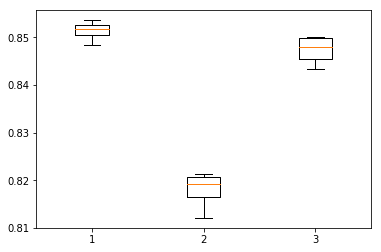

In [46]:
plt.boxplot(np.array(scores).T)
plt.show()

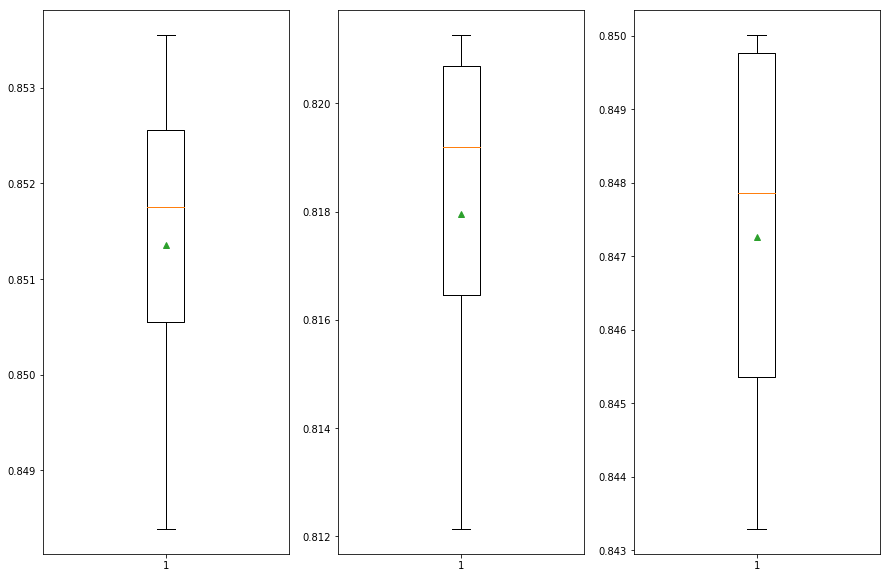

In [43]:

import matplotlib.pyplot as plt
def box_plot(data, filename=None):
    if filename != None:
        np.save("data/matrices/{}.npy".format(filename), data)
        
    f, axes = plt.subplots(1, data.shape[1], figsize=(15, 10))
    for i, axis in enumerate(list(axes)):
        axis.boxplot(data[:, i], 0, '', showmeans=True)
    
    if filename != None:
        plt.savefig("data/plots/{}.png".format(filename))
    
    plt.show()

box_plot(np.array(scores).T)

# Submission

In [22]:
y_submission = np.zeros(test_size)
for y, mask in zip(ys_sub, data_masks):
    mask = mask[train_size:]
    y_submission[mask] = y

In [23]:
create_csv_submission(indices_test, y_submission, "submissions/pred28.csv")